<a href="https://colab.research.google.com/github/sdam-au/PHI_ETL/blob/master/scripts/1_4_MODELLING_DATES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements & Auth



In [1]:
import requests
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# our own package for reading the data
!pip install sddk
import sddk

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [128]:
# read and execute our script for modelling dates
script_url = "https://raw.githubusercontent.com/sdam-au/modelling_temporal_uncertainty/master/scripts/modelling_distributions.py"
# execute the script
exec(requests.get(script_url).content)

In [3]:
# login to sciencedata 
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [4]:
# read the PHI dataset from sciencedata.dk
# (takes some time - the dataset has almost 400MB)
PHI = sddk.read_file("SDAM_data/PHI/PHI_cleaned_dated_2020-06-30.json", "df", conf)
# older version used during development: PHI = sddk.read_file("SDAM_data/PHI/PHI_enriched_raw.json", "df", conf)
# print first 5 rows of the data
PHI.head(5)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link
0,https://epigraphy.packhum.org/text/1,IG I³,1,Regions\n\nAttica (IG I-III)Attica,None,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,None,12.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,IG-I-3.csv,1,Regions\nAttica (IG I-III)Attica,IG I³\n1,ἔδοχσεν το͂ι δέμοι ταλαμος οἰκε͂ν ἐᾶ Σαλαμῖνι ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,c. 510-500 a.,"{'or': None, 'not_before': -511, 'not_after': ...",-511.0,-499.0,None,"[range, phase, ca]",None,None
1,https://epigraphy.packhum.org/text/2,IG I³,2,Regions\n\nAttica (IG I-III)Attica,None,Att. — non-stoich. — c. 500 a.,None,14.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n,[․․8-9․․․]ν̣ βολ — — — — — — — — — —\n[․6-7․․]...,IG-I-3.csv,2,Regions\nAttica (IG I-III)Attica,IG I³\n2,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,"․․ ․․․ν βολ ․ ․․ α ⋮ ℎεκον σιον, γνοσθε͂ι δὲ ν...",c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None
2,https://epigraphy.packhum.org/text/3,IG I³,3,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 21 — 490-480 a.,None,13.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n,[․]αρ[․․․․]ι ℎερακλειο[․․5․․]\n[․]αρ̣ο#⁷[․] τι...,IG-I-3.csv,3,Regions\nAttica (IG I-III)Attica,IG I³\n3,αρι ℎερακλειο αρο τιθέναι τὸς ἀέτας τριάκοντα ...,αρι ℎερακλειο αρο τιθέναι τὸς ἀθλοθέτας τριάκο...,αρι ℎερακλειο․․․․ αρο τιθέναι τὸς ἀθλοθέτας τρ...,490-480 a.,"{'or': None, 'not_before': -490, 'not_after': ...",-490.0,-480.0,None,[range],None,None
3,https://epigraphy.packhum.org/text/4,IG I³,4,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 38 — 485/4 a.,None,58.0,\nface A.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n\...,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,IG-I-3.csv,4,Regions\nAttica (IG I-III)Attica,IG I³\n4,δέ τις αν ἒ φρορὰν μ ντέκοντα δχμὰς τ ας ℎες π...,ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...,․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․ ․․․․․․․․․...,485/4 a.,"{'or': None, 'not_before': -485, 'not_after': ...",-485.0,-484.0,None,[range],None,None
4,https://epigraphy.packhum.org/text/5,IG I³,5,Regions\n\nAttica (IG I-III)Attica,None,Att. — c. 500 a.\n\nSee also:\nI.Eleusis 13,None,6.0,\n1\n\n\n\n \n5\n\n,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,IG-I-3.csv,5,Regions\nAttica (IG I-III)Attica,IG I³\n5,ν καὶ ο͂ι δέμοι ℎότε Παραιβάτες λεια θν τὸς ℎι...,ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...,ἔδοχσεν ⋮ τε͂ι βολε͂ι ⋮ καὶ το͂ι δέμοι ⋮ ℎότε ...,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None


In [5]:
### how many of the inscriptions have at least one date
len(PHI[(PHI["not_before"].notnull()) | (PHI["not_after"].notnull())])

130533

# Generate random dates for the whole dataset

In [5]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
PHI["random_dates"] = PHI.apply(lambda row: model_date(row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 1min 30s, sys: 2.9 s, total: 1min 33s
Wall time: 1min 33s


In [6]:
PHI.head(20)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link,random_dates
0,https://epigraphy.packhum.org/text/1,IG I³,1,Regions\n\nAttica (IG I-III)Attica,None,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,None,12.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,IG-I-3.csv,1,Regions\nAttica (IG I-III)Attica,IG I³\n1,ἔδοχσεν το͂ι δέμοι ταλαμος οἰκε͂ν ἐᾶ Σαλαμῖνι ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,c. 510-500 a.,"{'or': None, 'not_before': -511, 'not_after': ...",-511.0,-499.0,None,"[range, phase, ca]",None,None,"[-510, -504, -507, -508, -501, -501, -506, -50..."
1,https://epigraphy.packhum.org/text/2,IG I³,2,Regions\n\nAttica (IG I-III)Attica,None,Att. — non-stoich. — c. 500 a.,None,14.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n,[․․8-9․․․]ν̣ βολ — — — — — — — — — —\n[․6-7․․]...,IG-I-3.csv,2,Regions\nAttica (IG I-III)Attica,IG I³\n2,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,"․․ ․․․ν βολ ․ ․․ α ⋮ ℎεκον σιον, γνοσθε͂ι δὲ ν...",c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None,"[-504, -501, -499, -501, -499, -505, -500, -49..."
2,https://epigraphy.packhum.org/text/3,IG I³,3,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 21 — 490-480 a.,None,13.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n,[․]αρ[․․․․]ι ℎερακλειο[․․5․․]\n[․]αρ̣ο#⁷[․] τι...,IG-I-3.csv,3,Regions\nAttica (IG I-III)Attica,IG I³\n3,αρι ℎερακλειο αρο τιθέναι τὸς ἀέτας τριάκοντα ...,αρι ℎερακλειο αρο τιθέναι τὸς ἀθλοθέτας τριάκο...,αρι ℎερακλειο․․․․ αρο τιθέναι τὸς ἀθλοθέτας τρ...,490-480 a.,"{'or': None, 'not_before': -490, 'not_after': ...",-490.0,-480.0,None,[range],None,None,"[-484, -485, -487, -481, -483, -482, -484, -48..."
3,https://epigraphy.packhum.org/text/4,IG I³,4,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 38 — 485/4 a.,None,58.0,\nface A.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n\...,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,IG-I-3.csv,4,Regions\nAttica (IG I-III)Attica,IG I³\n4,δέ τις αν ἒ φρορὰν μ ντέκοντα δχμὰς τ ας ℎες π...,ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...,․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․ ․․․․․․․․․...,485/4 a.,"{'or': None, 'not_before': -485, 'not_after': ...",-485.0,-484.0,None,[range],None,None,"[-484, -484, -485, -484, -484, -484, -485, -48..."
4,https://epigraphy.packhum.org/text/5,IG I³,5,Regions\n\nAttica (IG I-III)Attica,None,Att. — c. 500 a.\n\nSee also:\nI.Eleusis 13,None,6.0,\n1\n\n\n\n \n5\n\n,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,IG-I-3.csv,5,Regions\nAttica (IG I-III)Attica,IG I³\n5,ν καὶ ο͂ι δέμοι ℎότε Παραιβάτες λεια θν τὸς ℎι...,ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...,ἔδοχσεν ⋮ τε͂ι βολε͂ι ⋮ καὶ το͂ι δέμοι ⋮ ℎότε ...,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None,"[-496, -500, -496, -496, -499, -500, -497, -50..."
5,https://epigraphy.packhum.org/text/6,IG I³,6,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 23/11 — ante 460 a.\n\nSee also...,None,168.0,\nface A.BM 309.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n...,— — — — — — — — — — — — —\n[․․․․․․15․․․․․․․] δ...,IG-I-3.csv,6,Regions\nAttica (IG I-III)Attica,IG I³\n6,δραχμε͂ιστες τὸς ιο μενος δεμο το͂ν πόλεο οκε͂...,δραχμε͂ισι τες τὸς ιο μενος δεμο το͂ν πόλεον δ...,․․․․․․․․․․․․․ δραχμε͂ισι ․․․․․․․․․․․․τες τὸς ι...,ante 460 a.,"{'or': None, 'not_before': None, 'not_after': ...",NaN,-461.0,None,[ante],None,None,"[-487, -507, -465, -479, -468, -467, -477, -47..."
6,https://epigraphy.packhum.org/text/7,IG I³,7,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 40 — 460-450,None,29.0,\nfrg. a.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n1...,[ἔδοχσεν τε͂]ι βο[λ]ε͂[ι καὶ 

# PHI dataset overview

In [7]:
len(PHI)

216702

In [9]:
len(PHI[PHI["random_dates"].notna()])

130533

In [8]:
# how many are dated / generated random numbers
len(PHI[PHI["random_dates"].notna()]) / len(PHI)

0.6023617686961819

In [160]:
len(PHI[(PHI["not_before"] >= -800) & (PHI["not_before"] <= 400)])

124061

In [173]:
# post quem
post = PHI[PHI["not_before"].notna() & (PHI["not_after"].isna())]
len(post)

3678

In [172]:
# ante quem
ante = PHI[PHI["not_after"].notna() & (PHI["not_before"].isna())]
len(ante)

806

In [175]:
ranges = PHI[PHI["not_after"].notna() & (PHI["not_before"].notna())]
len(ranges)

126049

In [177]:
# just for checking...
len(ranges) + len(ante) + len(post)

130533

# Regions

In [194]:
set([reg.partition("ions\n")[2].partition(" (")[0] for reg in PHI["hdr1"].unique().tolist()])

{'\nAttica',
 'Aegean Islands, incl. Crete',
 'Asia Minor',
 'Asia Minor\nAeolis',
 'Asia Minor\nArmenia ',
 'Asia Minor\nBithynia',
 'Asia Minor\nCappadocia',
 'Asia Minor\nCaria ',
 'Asia Minor\nCaria, Rhodian Peraia ',
 'Asia Minor\nCilicia and Isauria',
 'Asia Minor\nGalatia',
 'Asia Minor\nIonia',
 'Asia Minor\nLycaonia',
 'Asia Minor\nLycia',
 'Asia Minor\nLydia',
 'Asia Minor\nMysia',
 'Asia Minor\nMysia [Kaïkos], Pergamon',
 'Asia Minor\nMysia [Upper Kaïkos] / Lydia',
 'Asia Minor\nPamphylia',
 'Asia Minor\nPhrygia',
 'Asia Minor\nPisidia',
 'Asia Minor\nPontus and Paphlagonia',
 'Asia Minor\nTroas',
 'Asia MinorAeolis',
 'Asia MinorArmenia',
 'Asia MinorBithynia',
 'Asia MinorCappadocia',
 'Asia MinorCaria',
 'Asia MinorCilicia and Isauria',
 'Asia MinorGalatia',
 'Asia MinorIberia and Colchis',
 'Asia MinorIonia',
 'Asia MinorLycaonia',
 'Asia MinorLycia',
 'Asia MinorLydia',
 'Asia MinorMysia [Kaïkos], Pergamon',
 'Asia MinorMysia [Upper Kaïkos] / Lydia',
 'Asia MinorPamphyl

In [181]:
PHI_attica = PHI[PHI["hdr1"].str.contains("Attica")]
len(PHI_attica)

32652

In [182]:
PHI_asia_minor = PHI[PHI["hdr1"].str.contains("Asia Minor")]
len(PHI_asia_minor)

50226

# Playing with random dates

In [134]:
%%time
PHI_complete_simulations = timeblocks_from_randoms(PHI, "random_dates", [-800, 400, 50])

CPU times: user 2min 26s, sys: 1.71 s, total: 2min 28s
Wall time: 2min 28s


In [135]:
PHI_complete_simulations[1]

[((-800, -751), 10),
 ((-750, -701), 58),
 ((-700, -651), 163),
 ((-650, -601), 248),
 ((-600, -551), 852),
 ((-550, -501), 2087),
 ((-500, -451), 3960),
 ((-450, -401), 4073),
 ((-400, -351), 6254),
 ((-350, -301), 8807),
 ((-300, -251), 8200),
 ((-250, -201), 9054),
 ((-200, -151), 8876),
 ((-150, -101), 7124),
 ((-100, -51), 4907),
 ((-50, -1), 4862),
 ((1, 50), 6174),
 ((51, 100), 6157),
 ((101, 150), 10284),
 ((151, 200), 10035),
 ((201, 250), 9115),
 ((251, 300), 5893),
 ((301, 350), 3102),
 ((351, 400), 2730)]

In [136]:
def desc_stat_from_simulations(simulations):
  tups_desc = []
  for n in range(len(simulations[0])):
    values = [sim[n][1] for sim in simulations]
    tups_desc.append((simulations[0][n][0], np.min(values), np.max(values), np.mean(values), np.median(values)))
  tups_desc_df = pd.DataFrame(tups_desc)
  tups_desc_df.columns = ["temp_block", "min", "max", "mean", "median"]
  return tups_desc_df

In [143]:
sims_by_blocks = desc_stat_from_simulations(PHI_complete_simulations)
sims_by_blocks.set_index("temp_block", inplace=True)
sims_by_blocks

,min,max,mean,median
temp_block,,,,
"(-800, -751)",6,18,11.637,12.0
"(-750, -701)",46,66,56.035,56.0
"(-700, -651)",136,193,161.479,161.0
"(-650, -601)",230,294,259.763,259.5
"(-600, -551)",817,956,882.303,882.0
"(-550, -501)",1967,2133,2056.019,2056.0
"(-500, -451)",3832,4049,3940.972,3940.0
"(-450, -401)",4001,4261,4115.200,4115.0
"(-400, -351)",6028,6353,6214.889,6217.5


In [18]:
from pandas.plotting import table

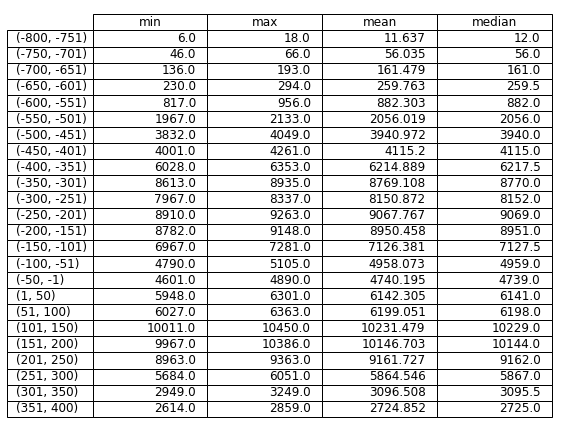

In [139]:
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)
tabla = table(ax, sims_by_blocks, loc='upper right', colWidths=[0.2]*len(sims_by_blocks.columns))
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) 

In [140]:
sddk.write_file("SDAM_data/temporal_uncertainty/sims_by_blocks.png", fig, conf)

A file with the same name ("sims_by_blocks.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/temporal_uncertainty/sims_by_blocks.png"


In [17]:
sddk.write_file("SDAM_data/temporal_uncertainty/sims_by_blocks.csv", sims_by_blocks, conf)

Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/temporal_uncertainty/sims_by_blocks.csv"


In [141]:
# compare in how many instances is there less inscriptions for the first half of the 2nd c. than for the second half.
len([sim for sim in PHI_complete_simulations if sim[18][1] < sim[19][1]])

214

In [148]:
len([date for date in PHI_date_avr if not np.isnan(date)])

126049

In [153]:
# for a comparison, generate dates based on average values
def get_avr(row):
  try: 
    avr = np.mean([row["not_before"], row["not_after"]])
  except:
    avr = np.nan
  return avr

PHI_date_avr = PHI.apply(lambda row: get_avr(row), axis=1)

PHI_avr_blocks = dates_per_block(PHI_date_avr, sims_by_blocks.index.tolist())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in less_equal


68257

In [155]:
PHI_date_avr

0        -505.0
1        -500.0
2        -485.0
3        -484.5
4        -500.0
          ...  
216697      NaN
216698      NaN
216699    550.5
216700      NaN
216701      NaN
Length: 216702, dtype: float64

In [154]:
pd.DataFrame(PHI_avr_blocks)[1].sum()

68257

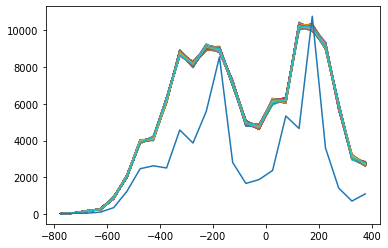

In [145]:
plot_timeblocks_data(PHI_complete_simulations)
x = [np.mean(tuptup[0]) for tuptup in PHI_avr_blocks]
y = [tuptup[1] for tuptup in PHI_avr_blocks]
plt.plot(x, y)

In [44]:
# creating a subdataframe
PHI_athens = PHI[PHI["tildeinfo"].str.contains("Athen", na=False)]
PHI_athens.head(5)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link,random_dates
79,https://epigraphy.packhum.org/text/80,IG I³,"78,b",Regions\n\nAttica (IG I-III)Attica,None,Att. — Athens — stoich. 50 — c. 422 a.?\n\nSee...,None,9.0,\n14\n\n15\n\n\n\n\n\n20\n\n\n,"[ἐγλο]-\n[γέας ℎελέσθαι τ]ο͂ καρπο͂, [καθότι ἂ...",IG-I-3.csv,80,Regions\nAttica (IG I-III)Attica,"IG I³\n78,b",ο͂ καρπο͂ αι ἐπειδὰντας παραδισῖνάδε ἐὰν δὲ με...,ἐγλογέας ℎελέσθαι το͂ καρπο͂ καθότι ἂν δοκε͂ι ...,"ἐγλογέας ℎελέσθαι το͂ καρπο͂, καθότι ἂν δοκε͂ι...",c. 422 a.?,"{'or': None, 'certainty': '?', 'not_before': N...",NaN,NaN,None,"[unknown, phase, ca]",?,None,None
159,https://epigraphy.packhum.org/text/160,IG I³,157/213,Regions\n\nAttica (IG I-III)Attica,None,Att. — Athens: Akropolis — stoich. 28 — 440-41...,None,35.0,\na.1\n\n\n\n\n5\n\n\nb.6\n\n\n\n\n10\n\n\n\n\...,[— —․․]οπε— —\n— —θεσεπ— —\n— —εζοσι— —\n— —υπ...,IG-I-3.csv,160,Regions\nAttica (IG I-III)Attica,IG I³\n157/213,οπε θεσεπ εζοσι υποτο να lacuna συμμ ναίον ℎ μ...,οπε θεσεπ εζοσι υποτο να lacuna χσυμμαχ Ἀθεναί...,․․οπε θεσεπ εζοσι υποτο ․․․να lacuna ․․․․ χσυμ...,440-410 a.,"{'or': None, 'not_before': -440, 'not_after': ...",-440.0,-410.0,None,[range],None,None,"[-434, -422, -420, -432, -420, -423, -431, -43..."
416,https://epigraphy.packhum.org/text/417,IG I³,403,Regions\n\nAttica (IG I-III)Attica,None,Att. — Athens — stoich. — c. 416/5 a.,None,85.0,\nface A front.frg. a\n\n1\n\n\n\n\n5\n\n\n\n\...,— — — — — — — — — — — — — — — — — — — — — — — ...,IG-I-3.csv,417,Regions\nAttica (IG I-III)Attica,IG I³\n403,σχ ινα χρυσ σο͂ ἀπὸ μὸν τ Ι στλι πα χρυ συλοι ...,σχ ινα χρυσ χρυσο͂ ἀπὸ το͂ σταθμὸν τ Ι στλιγγὶ...,․․․․․․․σχ ․․․․․․․ινα ․․․․․․χρυσ ․․ χρυσο͂ ἀπὸ ...,c. 416/5 a.,"{'or': None, 'not_before': -416, 'not_after': ...",-416.0,-415.0,None,"[range, phase, ca]",None,None,"[-415, -416, -416, -415, -415, -415, -415, -41..."
417,https://epigraphy.packhum.org/text/418,IG I³,404,Regions\n\nAttica (IG I-III)Attica,None,Att. — Athens — stoich. — c. 416/5 a.,None,43.0,\nfrg. a.1\n\n\n\n\n5\n\n\n\n\n8a\n\nfrg. b.8b...,— — —\n[— — ․]𐅃․ — —\n— — ιν ⋮Ι — — —\n— — φαν...,IG-I-3.csv,418,Regions\nAttica (IG I-III)Attica,IG I³\n404,𐅃 ιν Ι φαν ος Ι σαρ ος χ ισ Ι Δ οα Ι ΟΥ νοι ελ...,𐅃 ιν Ι φαν ος Ι σαρ ος χ ισ Ι Δ οα Ι ΟΥ νοι ελ...,․𐅃․ ιν ⋮Ι φαν ος ⋮Ι σαρ ος χ ․ισ ․Ι ․ ⋮Δ οα . ...,c. 416/5 a.,"{'or': None, 'not_before': -416, 'not_after': ...",-416.0,-415.0,None,"[range, phase, ca]",None,None,"[-415, -416, -416, -415, -416, -416, -416, -41..."
516,https://epigraphy.packhum.org/text/517,IG I³,502,Regions\n\nAttica (IG I-III)Attica,None,Att. — Athens: Agora — 477/6 a. — Hsp. 5.1936....,None,2.0,\n1\n\n,[ἐ͂ μέγ’ Ἀθεναίοισι φόος γένεθ’ ℎενίκ’ Ἀριστο...,IG-I-3.csv,517,Regions\nAttica (IG I-III)Attica,IG I³\n502,ℎαρμόδιο τρίδα γε͂ν ἐθέτεν,ἐ͂ μέγ’ Ἀθεναίοισι φόος γένεθ’ ℎενίκ’ Ἀριστογ...,ἐ͂ μέγ’ Ἀθεναίοισι φόος γένεθ’ ℎενίκ’ Ἀριστογ...,477/6 a.,"{'or': None, 'not_before': -477, 'not_after': ...",-477.0,-476.0,None,[range],None,None,"[-476, -477, -477, -476, -477, -477, -476, -47..."


In [124]:
athens_sim = timeblocks_from_randoms(PHI_athens, "random_dates", [-800, 400, 50])

In [125]:
athens_sim[0]

[((-800, -751), 1),
 ((-750, -701), 8),
 ((-700, -651), 7),
 ((-650, -601), 14),
 ((-600, -551), 111),
 ((-550, -501), 356),
 ((-500, -451), 1090),
 ((-450, -401), 614),
 ((-400, -351), 824),
 ((-350, -301), 1469),
 ((-300, -251), 968),
 ((-250, -201), 924),
 ((-200, -151), 605),
 ((-150, -101), 368),
 ((-100, -51), 248),
 ((-50, -1), 264),
 ((1, 50), 206),
 ((51, 100), 209),
 ((101, 150), 299),
 ((151, 200), 354),
 ((201, 250), 221),
 ((251, 300), 139),
 ((301, 350), 113),
 ((351, 400), 72)]

11224


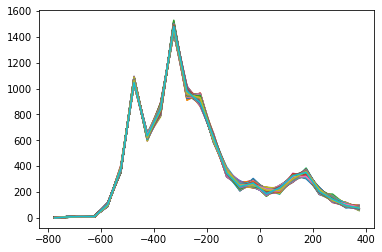

In [110]:
print(len(PHI_athens))
plot_timeblocks_data(athens_sim)

In [112]:
desc_stat_from_simulations(athens_sim)

,temp_block,min,max,mean,median,variance
0,"(-800, -750)",0,3,1.228,1.0,0.702016
1,"(-750, -700)",4,12,7.751,8.0,1.636999
2,"(-700, -650)",5,15,9.705,10.0,2.533975
3,"(-650, -600)",6,17,10.997,11.0,2.998991
4,"(-600, -550)",86,118,102.925,103.0,23.853375
5,"(-550, -500)",349,408,374.583,375.0,75.037111
6,"(-500, -450)",1028,1094,1061.648,1061.0,135.646096
7,"(-450, -400)",594,660,628.545,628.0,105.127975
8,"(-400, -350)",781,889,835.509,835.0,262.669919
9,"(-350, -300)",1419,1528,1471.713,1471.0,266.880631


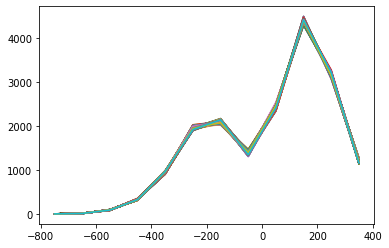

In [113]:
PHI_asia_minor = PHI[PHI["hdr1"].str.contains("Asia Minor")]
PHI_asia_minor_sim = timeblocks_from_randoms(PHI_asia_minor, "random_dates", [-800, 400, 100])
plot_timeblocks_data(PHI_asia_minor_sim)